In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from wordcloud import WordCloud ### For visualising the frequent words
import re
import random
import string
import math

# Mute general warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,LSTM
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import Callback

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
plt.style.use('fivethirtyeight')

Set Random Seed

Permutation Importance

Learning rate scheduler

Keras Tuner

## Data Inspection:

#### Reading the DataFrame

In [5]:
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


#### Basic Info

In [6]:
print(f"There are {df.shape[0]} ROWS and {df.shape[1]}")

There are 1600000 ROWS and 6


#### The dataset contains **1.6 Million** Tweets and I find it a good amount of data to train our model.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
df.columns

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')

#### Renaming the columns properly::

In [9]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']

##### Here "sentiment" is the target variable.

In [10]:
df["sentiment"].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

#### Here,

##### **0** represents a Negative Sentiment

##### **4** represents a Positive Sentiment

In [11]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
df.sentiment = df.sentiment.apply(lambda x: lab_to_sentiment[x])
df.head()

,sentiment,id,date,query,user_id,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Target Distribution')

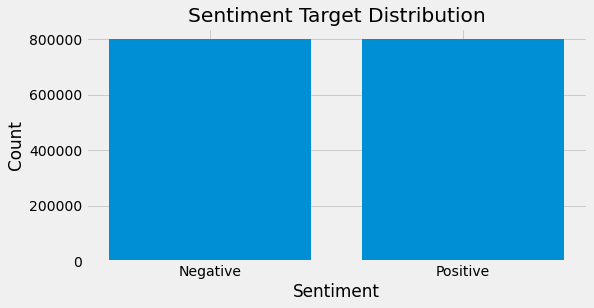

In [12]:
### Visualising the distribution of the target variable.
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Target Distribution")

#### There is no class imbalance.

#### Now let us explore the data we having here...

In [13]:
### randomly selecting rows and printing them
ind=np.random.randint(0,1000,(10)) 
df.iloc[ind].text

626                                        wants to cry 
666                @ryanmwilson aww that stinks!  *hugs*
678    Of course the baby is screaming in the crib th...
329            @thecoolestout Ha the sun's already gone 
137    @BridgetsBeaches Thank you for letting people ...
512    @pratama Same iMac came out $320 more in Indon...
74     Why won't you show my location?!   http://twit...
663                  im sooo sad right now  i need a hug
10           spring break in plain city... it's snowing 
153           Living not downtown sure isn't much fun.  
Name: text, dtype: object

#### Looks like we have so much to clean!

## Text Preprocessing:

- Tweets usually contain unnecessary data like **user mentions**, **hyperlink texts**, **emoticons** and **punctuations**. 

- In order to use text for learning, we need to clean them before training a model. 

### The following steps are going to be incorporated while cleaning::

### 1. Tokenisation - 

Tokenization is used in natural language processing to split paragraphs and sentences into smaller units that can be more easily assigned meaning. 

The first step of the NLP process is gathering the data (a sentence) and breaking it into understandable parts (words).

### 2. Stopwords - 

Stop words are a set of commonly used words in any language. For example, in English, “the”, “is” and “and”, would easily qualify as stop words.

The list of inbuilt stopwords has been displayed below.

### 3. Hyperlink Texts and Removals - 

Twitter User Mentions - Eg. @sudhar, @andrewng

Hyperlinks - Eg. https://keras.io, https://tensorflow.org

### 4. Punctuation Mark Removal - 

We do it after step 3 as we wont be able to match with any pattern if done before.

### 5. Stemming/Lemmatization - 

Lemmatization and Stemming are **Text Normalization** techniques. These techniques are used to prepare words, text, and documents for further processing.

Lemmatization takes **more time**(**computationally expensive**) as compared to stemming because it finds meaningful word/ representation. Stemming just needs to get a base word and therefore takes less time. Hence Stemming is used in large datasets.

WordNetLemmatizer ---> Lemmatizing

SnowBallStemmer ---> Stemming

### 6. Spelling Correction -

In this notebook, I have used the python package **pyspellchecker** for correcting spellings.

In [48]:
## Getting a list of stop words in English:
stop_words = stopwords.words('english')

#### Pattern removing Hyperlinks and Mentions:
pattern = "(@\S+)|(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])"

## List of Punctuation marks:
punct=string.punctuation

## Setting a Stemmer Object:
stemmer = SnowballStemmer('english')

## Function to remove numbers:
def remove_numb(text):
    return re.sub("[0-9]+","",text)

In [ ]:
### Function for spelling-checker:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

##### Having a look at the different stopwords available under NLTK:

In [15]:
### Stop words offered by NLTK:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [20]:
### Viewing the number of rows having MENTIONS:
v=[]
for i in df.text:
    v.append(re.findall(r'(@\S+)',i))   
    
v1=[i for i in v if len(i)!=0]
print(f"There are {len(v1)} rows with Mentions(@yyy) in their text")

There are 738822 rows with Mentions(@yyy) in their text


In [21]:
### Viewing the number of rows having HYPERLINKS:
v=[]
for i in df.text:
    v.append(re.findall(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])',i))   

v2=[i for i in v if len(i)!=0]
print(f"There are {len(v2)} rows with Hyperlinks(http://yyy) in their text")

There are 70065 rows with Hyperlinks(http://yyy) in their text


In [18]:
v1[:10]

[['@switchfoot'],
 ['@Kenichan'],
 ['@nationwideclass'],
 ['@Kwesidei'],
 ['@LOLTrish'],
 ['@Tatiana_K'],
 ['@twittera'],
 ['@caregiving'],
 ['@octolinz16'],
 ['@smarrison']]

In [19]:
v2[:10]

[[('http', 'twitpic.com', '/2y1zl')],
 [('http', 'is.gd', '/fNge')],
 [('http', 'tinyurl.com', '/dcuc33')],
 [('http', 'twitpic.com', '/2y2es')],
 [('http', 'apps.facebook.com', '/dogbook/profile/view/5248435')],
 [('http', 'tr.im', '/imji')],
 [('http', 'apps.facebook.com', '/dogbook/profile/view/6176014')],
 [('http', 'ff.im', '/1XTTi')],
 [('http', 'www.erika-obscura.blogspot.co', 'm')],
 [('http', 'twitpic.com', '/2y2wr')]]

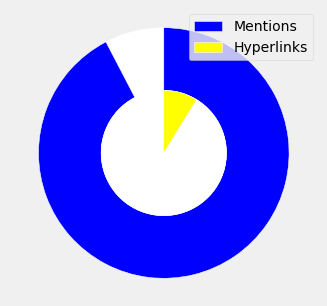

In [41]:
labels = ["Mentions","Hyperlinks"]
data = [len(v1),len(v2)]
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(math.log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = ["blue","yellow"]

#create figure, axis
fig, ax = plt.subplots(figsize=(5,5))
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 0}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")

plt.legend()
plt.show()

In [49]:
def funct_clean(x,stem=False):
    ### Removing Mentions and Hyperlinks:
    sentence = re.sub(pattern, ' ', str(x).lower()).strip()
    ### Converting to lower case:
    sentence = sentence.lower()
    ### Removing punctuation marks:
    sentence=sentence.translate(str.maketrans('', '', punct))
    ### Tokenising:
    words = word_tokenize(sentence)
    tokens = []
    for token in words:
        if token not in stop_words:   ### Checking whether the token is a stop word
            if stem:
                tokens.append(stemmer.stem(token))  ### Stemming the token(Less time taken)
            else:
                tokens.append(token)
    ### removing numbers and checking spelling and finally returning       
    return correct_spellings(remove_numb(" ".join(tokens)))  

In [59]:
%%time

df["text_pre"] = df.text.apply(lambda x: funct_clean(x,1))

CPU times: user 6min 15s, sys: 439 ms, total: 6min 16s
Wall time: 6min 16s


In [ ]:
#### subset of the data to inspect
data=df.iloc[:1000].copy()
data[["text","text_pre"]]

In [60]:
df.columns

Index(['sentiment', 'id', 'date', 'query', 'user_id', 'text', 'text_new'], dtype='object')

#### Well done, the text is clean!

#### Now let's visualise our clean text using WordCloud Plots

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

## Vectorizing: